In [1]:
!pip install --upgrade kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 819.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=9ec75332f6fda80d2729b03694281c0f448c234aff6ab417b5681ae9dc3c50a0
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.14
    Uninstalling kaggle-1.6.14:
      Successfully uninstalled kaggle-1.6.14


In [2]:
# Libraries
import os
import json
import shutil
import zipfile
import re

#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Kaggle API Using Secrets

from kaggle_secrets import UserSecretsClient

# Brought key info
user_secrets = UserSecretsClient()
kaggle_key = user_secrets.get_secret("jiyoungroh")

# Setting
os.environ['KAGGLE_KEY'] = kaggle_key
os.environ['KAGGLE_USERNAME'] = "jiyoungroh"

In [4]:
!kaggle competitions download -c playground-series-s4e8

 85%|█████████████████████████████████▏     | 70.0M/82.3M [00:00<00:00, 153MB/s]
100%|███████████████████████████████████████| 82.3M/82.3M [00:00<00:00, 177MB/s]


# 1. EDA

In [5]:
# Unzip
with zipfile.ZipFile('/kaggle/working/playground-series-s4e8.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

# Loading Data
train_data = pd.read_csv('/kaggle/working/train.csv')
test_data = pd.read_csv('/kaggle/working/test.csv')
sample_submission = pd.read_csv('/kaggle/working/sample_submission.csv')

In [6]:
pd.set_option('display.max_columns', None)
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [7]:
# missing value
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()

print("Train Data Missing Values:\n", missing_values_train[missing_values_train > 0])
print("\nTest Data Missing Values:\n", missing_values_test[missing_values_test > 0])

Train Data Missing Values:
 cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
dtype: int64

Test Data Missing Values:
 cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                   49
stem-height                   1
stem-root               1838012
stem-surface            1321488
stem-color                   21
vei

In [8]:
# Row Number
total_rows = len(train_data)
print(f"Total rows in train_data: {total_rows}")

# Missing Value Rate
nan_percentage = (train_data.isnull().sum() / total_rows) * 100
print("Percentage of NaN values in each column:\n", nan_percentage)

Total rows in train_data: 3116945
Percentage of NaN values in each column:
 id                       0.000000
class                    0.000000
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-height              0.000000
stem-width               0.000000
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64


In [9]:
numerical_columns = ['cap-diameter', 'stem-height', 'stem-width']

categorical_columns = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
    'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
    'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

remove_categorical_columns = [
    'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
    'gill-attachment', 'gill-spacing', 'gill-color',
    'stem-surface', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season'
]

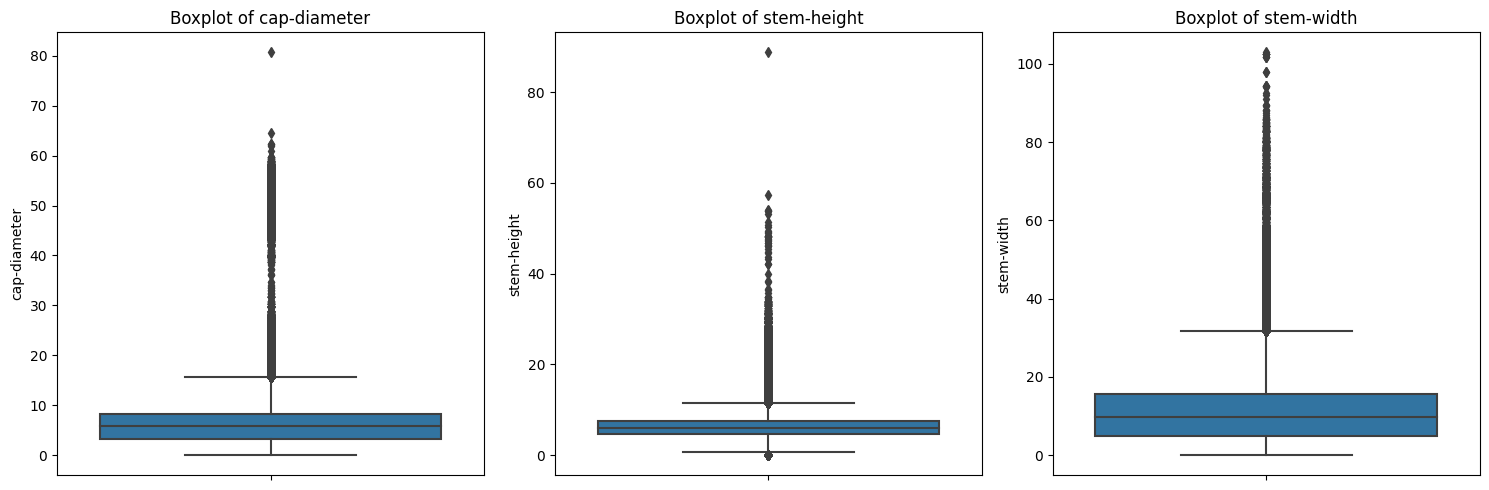

In [10]:
# Numeric Box Plot
plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=train_data[col])
    plt.title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

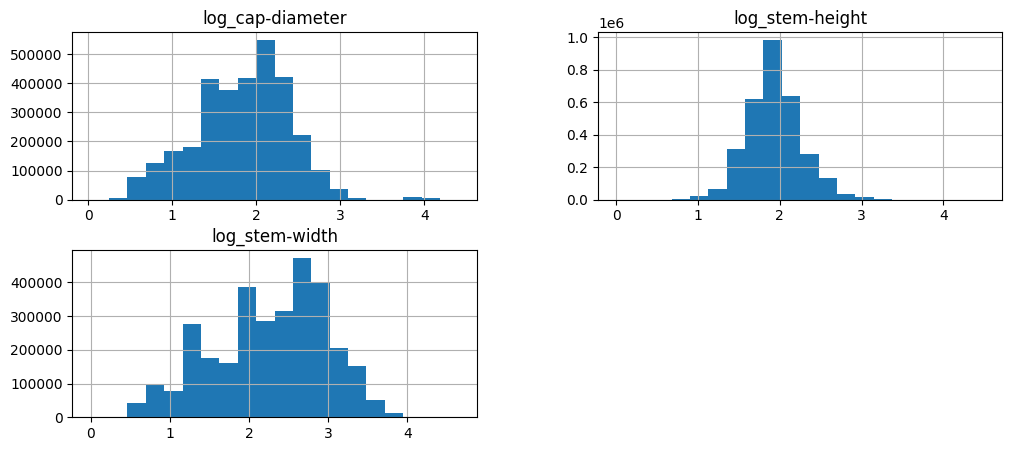

In [11]:
# Log Numeric Distribution
train_data['log_cap-diameter'] = np.log1p(train_data['cap-diameter'])
train_data['log_stem-height'] = np.log1p(train_data['stem-height'])
train_data['log_stem-width'] = np.log1p(train_data['stem-width'])

# Looks like Nomal Distribution :)
train_data[['log_cap-diameter', 'log_stem-height', 'log_stem-width']].hist(bins=20, figsize=(12, 5))
plt.show()

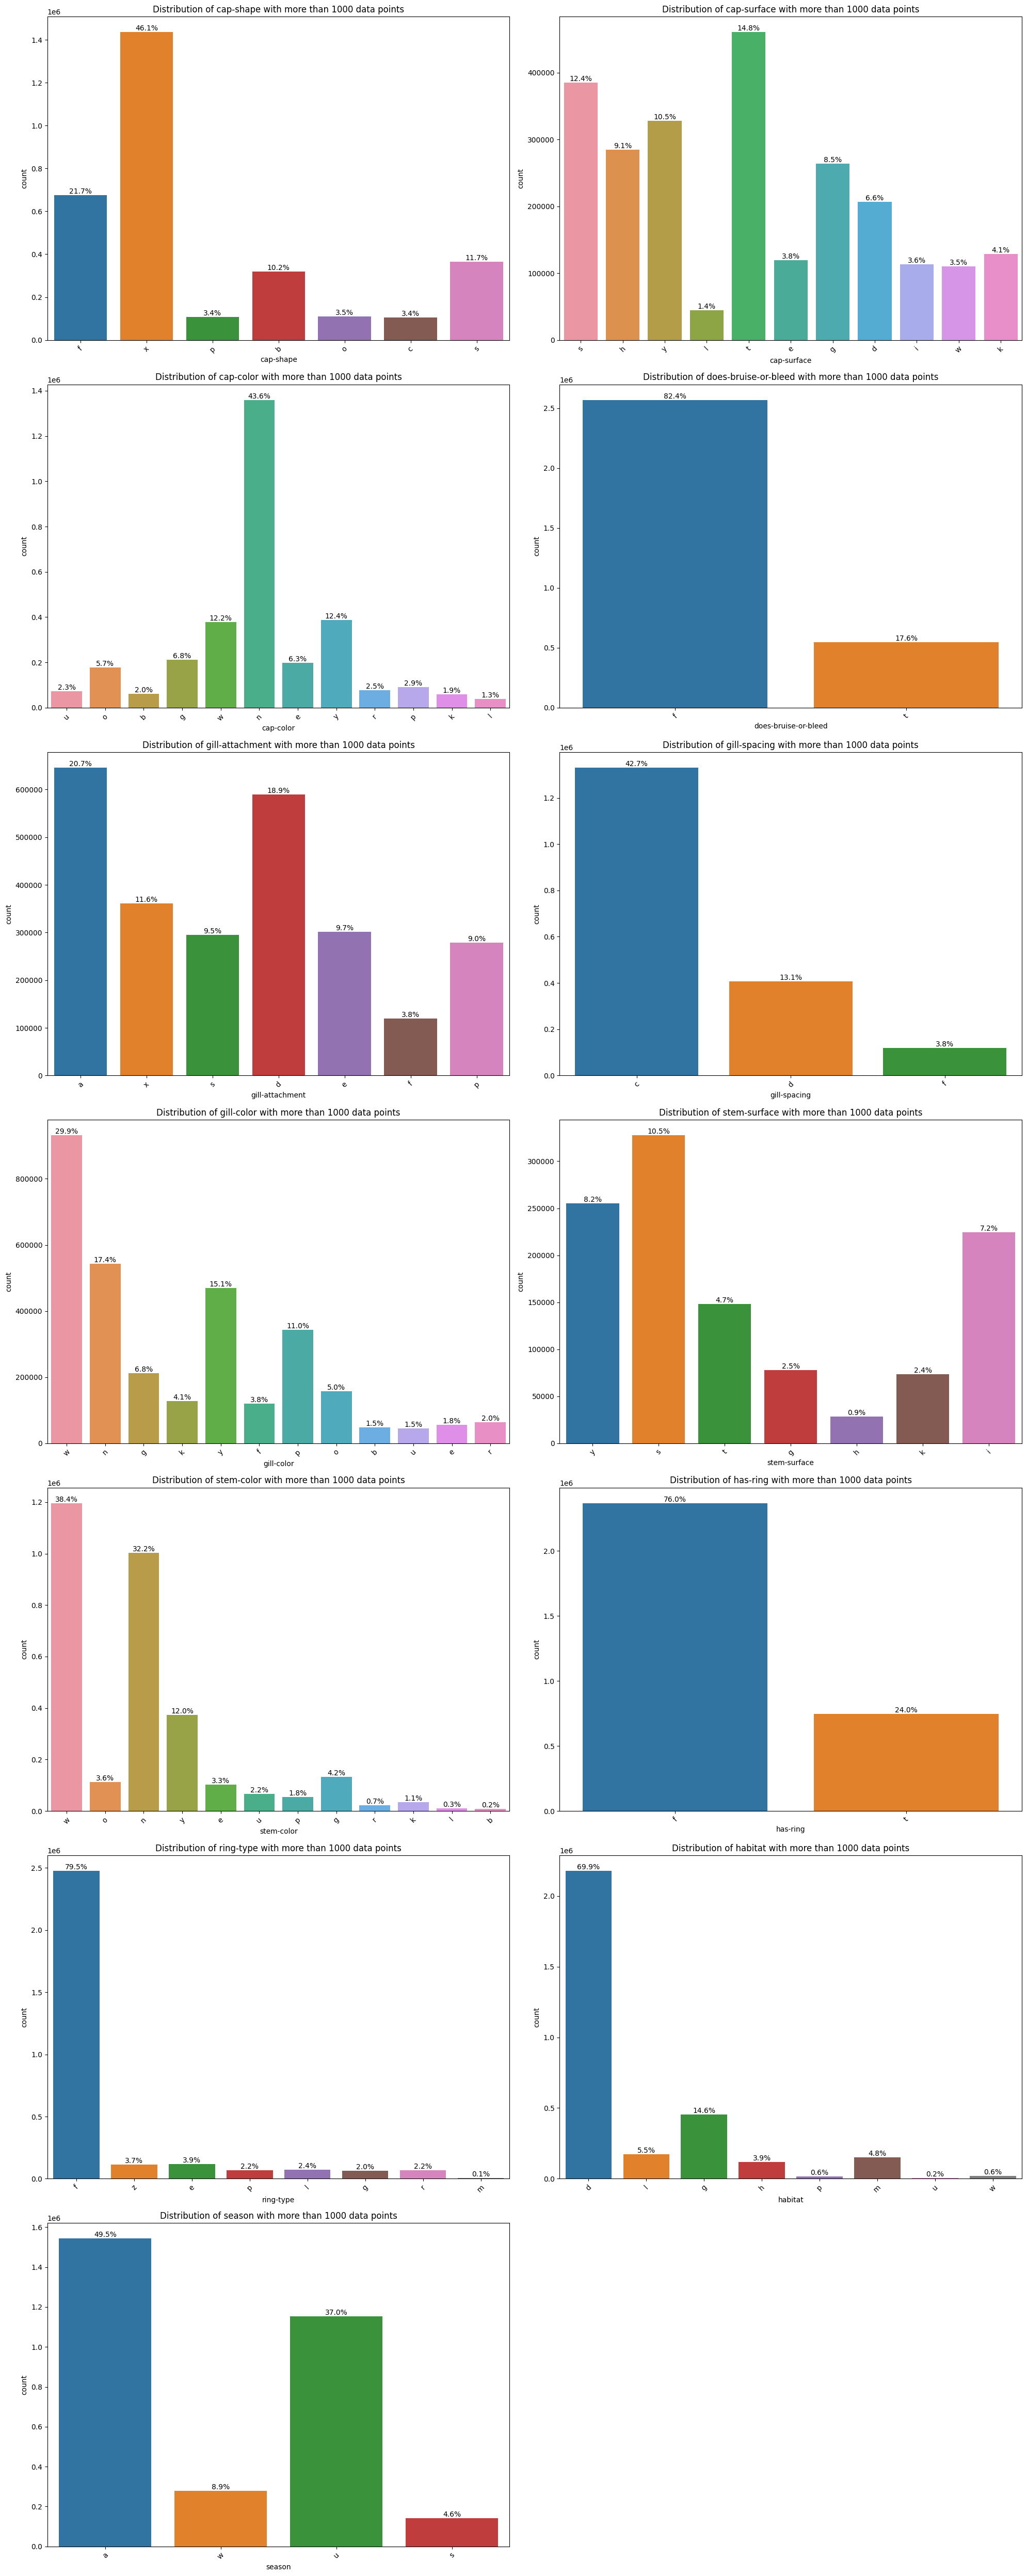

In [12]:
# At least 1000 data point labels distribution
plt.figure(figsize=(20, 50))

for i, col in enumerate(remove_categorical_columns, 1):
    plt.subplot(len(remove_categorical_columns) // 2 + 1, 2, i)
    filtered_data = train_data[col].value_counts()
    filtered_data = filtered_data[filtered_data > 1000].index
    sns.countplot(data=train_data[train_data[col].isin(filtered_data)], x=col)
    plt.title(f'Distribution of {col} with more than 1000 data points')
    plt.xticks(rotation=45)
    
    # 비율을 각 막대 위에 표시
    total = len(train_data)
    for p in plt.gca().patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        plt.gca().annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

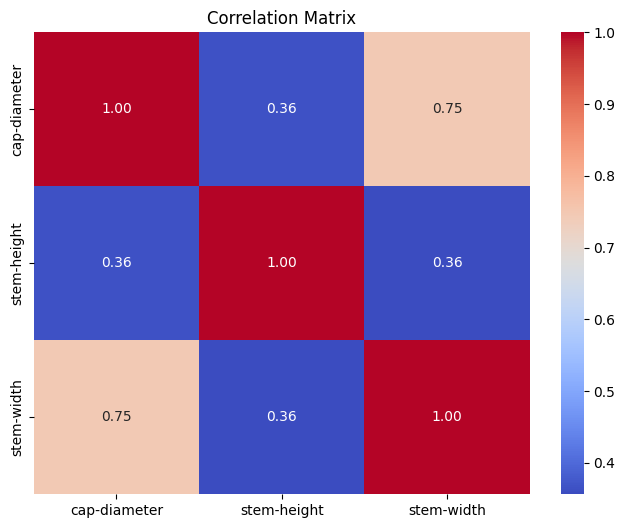

In [14]:
# Numeric Correlation Matrix
correlation_matrix = train_data[numerical_columns].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

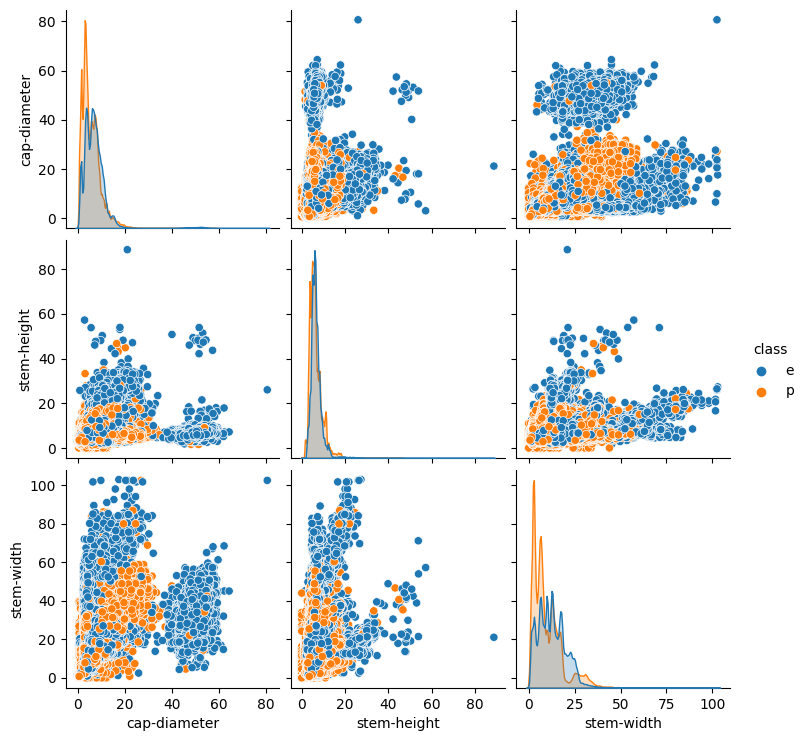

In [15]:
# Numerical columns pairplot with class
sns.pairplot(train_data[['cap-diameter', 'stem-height', 'stem-width', 'class']], hue='class')
plt.show()

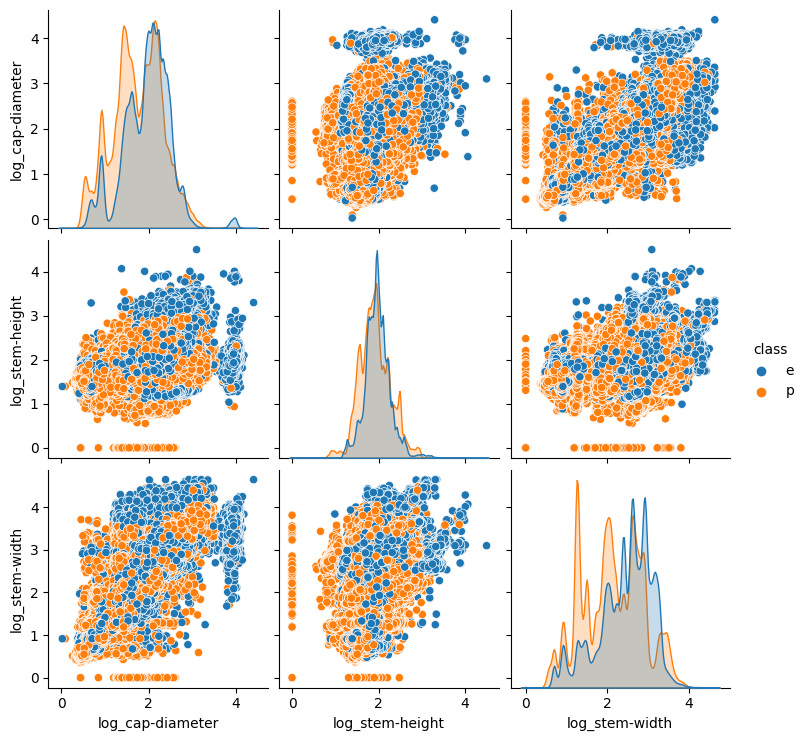

In [16]:
# Log Numerical columns pairplot with class
sns.pairplot(train_data[['log_cap-diameter', 'log_stem-height', 'log_stem-width', 'class']], hue='class')
plt.show()

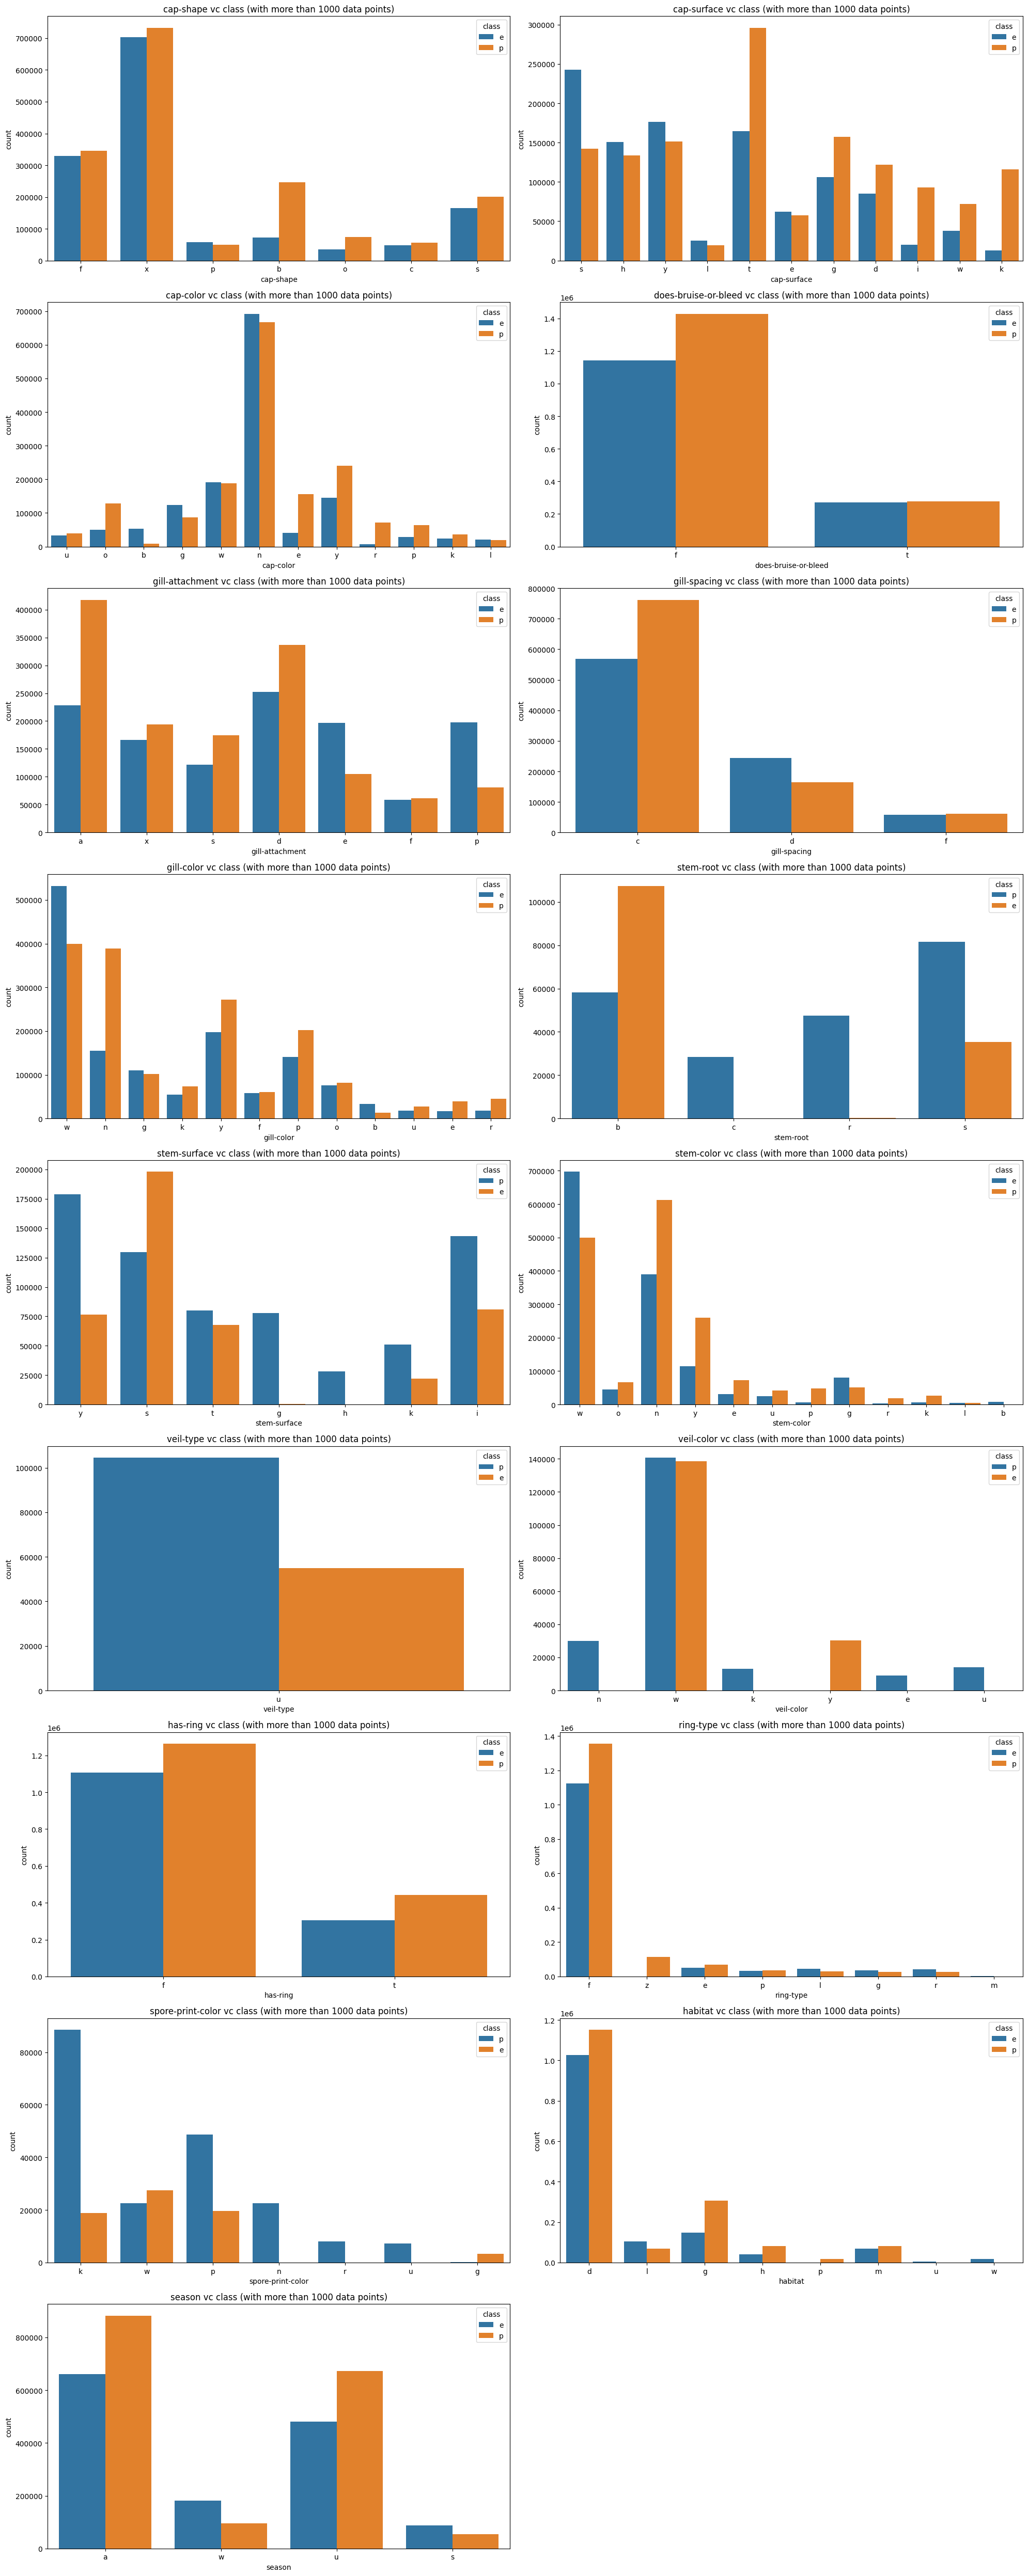

In [17]:
# Categorical columns Realationship with class

plt.figure(figsize=(20, 50))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 2 + 1, 2, i)
    filtered_data = train_data[col].value_counts()
    filtered_data = filtered_data[filtered_data > 1000].index
    sns.countplot(data=train_data[train_data[col].isin(filtered_data)], x=col, hue='class')
    plt.title(f'{col} vc class (with more than 1000 data points)')

plt.tight_layout()
plt.show()